In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from tqdm import tqdm
from matplotlib import cm

from iteration_utilities import flatten
import ipyparams
from helper_functions import propagate_deflected_muons_custom, get_angle_deviation, energy_name, get_zenith_deflections_along_track, save_data_along_dict, load_data_along_dict

<IPython.core.display.Javascript object>

In [2]:
save_plot = False

# currentNotebook = ipyparams.notebook_name[:len(ipyparams.notebook_name)-6] # get name of currect notebook
# assert currentNotebook != '', "no notebook name, run cell again"

currentNotebook = "deflection_along_sampling_test"

plot_dir = 'plots/{}/'.format(currentNotebook)
os.system('mkdir -p {}'.format(plot_dir))

df_dir = 'data/{}/'.format(currentNotebook)
os.system('mkdir -p {}'.format(df_dir))


colors = {
    'brems': cm.tab10(0),
    'nuclint': cm.tab10(1), 
    'epair': cm.tab10(2),
    'ioniz': cm.tab10(3) 
}

In [ ]:
cm.tab10

In [ ]:
n_events = 100 # 5000 # 1
E_i = 1e9 # 1 PeV (corresponds to MeV)
E_f = 1e6 # 1 TeV (corresponds to MeV)
E_i_final = np.ones(n_events) * E_i
E_f_final = np.ones(n_events) * E_f

table_path="/Users/pascalgutjahr/.cache/PROPOSAL" # lehrstuhl macbook

hdf_name = 'df_{}_{}_{}events.hdf'.format(energy_name(E_i), energy_name(E_f), n_events)
hdf_name

# Sample deflections along extern using energies of propagation

## Check energies!! GeV or MeV?!

In [24]:
### deflection parametrizations

# ------- bremsstrahlung --------
### Van Ginneken
def get_brems_rms_theta_vG_final(E, E_, Z=82, m=0.10566):
    nu = (E - E_) / (E - m)
    if nu <= 0.5:
        k_1 = 0.092 * E**(-1/3)
        k_2 = 0.052 / E * Z**(-1/4)
        k_3 = 0.22 * E**(-0.92)
        rms_theta = np.max([np.min([k_1 * np.sqrt(nu), k_2]), k_3 * nu])
        return rms_theta
    if nu > 0.5:
        k_4 = 0.26 * E**(-0.91)
        m = 0.5
        d = 1.8
        n = 0.81 * E**m / (E**m + d)
        rms_theta = k_4 * nu**(1+n) * (1 - nu)**(-n)
        if rms_theta < 0.2:
            return rms_theta
    if nu > 0.5:
        # k_5 = k_4 * nu**(1+n) * (1-nu)**(0.5-n)
        ###
        # x_min = 5e-5 # 5e-3
        # v = np.logspace(np.log10(x_min), np.log10(0.5), int(1e6))
        # nu_lin = 1 - v 
        # nu_g = nu_lin[np.argmin(abs(f_nu_g(nu_lin, f_n(E), f_k_4(E))))]
        ###
        nu_g = get_nu_g(E)
        ### nu_g = get_nu_g_1(E) # no relevant speed difference
        k_5 = k_4 * nu_g**(1+n) * (1-nu_g)**(0.5-n)
        rms_theta = k_5 * (1 - nu)**(-0.5)
        if rms_theta >= 0.2:
            return rms_theta
    else:
        assert False, 'nu_g = {}'.format(nu_g)
        
def f_nu_g(nu_g, n, k_4):
    return (nu_g**(1/n + 1) + (0.2/k_4)**(1/n) * nu_g - (0.2/k_4)**(1/n))

def f_n(E, m=0.5, d=1.8):
    return 0.81 * E**m / (E**m + d)

def f_k_4(E):
    return 0.26 * E**(-0.91)

def get_nu_g(E, x_min=5e-5):
    v = np.logspace(np.log10(x_min), np.log10(0.5), int(1e6))
    nu_lin = 1 - v 
    nu_g = nu_lin[np.argmin(abs(f_nu_g(nu_lin, f_n(E), f_k_4(E))))]
    return nu_g

def get_nu_g_1(E, x_min=5e-5):
    v = np.logspace(np.log10(x_min), np.log10(0.5), int(1e6))
    nu_lin = 1 - v 
    n = 0.81 * E**0.5 / (E**0.5 + 1.8)
    k_4 = 0.26 * E**(-0.91)
    nu_g = nu_lin[np.argmin(abs(f_nu_g(nu_lin, n, k_4)))]
    return nu_g

# sample from van Ginneken
def get_brems_theta_vG(E, E_, rnd_state, Z=1, is_degree=True):
    rms_theta = get_brems_rms_theta_vG_final(E, E_, Z=Z)
    theta_muon = np.sqrt(rnd_state.exponential(rms_theta**2))
    if is_degree:
        return np.rad2deg(theta_muon)
    else:
        return theta_muon

### Geant4 sampling 
def get_new_psi_brems(E, E_, rnd_state, is_degree=True, theta_star=1):
    epsilon = E - E_
    mu = 0.1057  # muon mass
    p = rnd_state.uniform(0, 1)
    r_max = np.minimum(1, E_/epsilon) * E * theta_star / mu
    a = p * r_max**2 / (1+r_max**2)
    r = np.sqrt(a/(1-a))
    theta_photon = mu / E * r
    theta_mu = epsilon / E_ * theta_photon
    
    if is_degree:
        return np.rad2deg(theta_mu)
    else:
        return theta_mu
    
# ----------- nuclint ----------
def get_new_psi_nuclint(E, E_, rnd_state, is_degree=True, nu_min=None, nu_max=True):
    M = 0.9383 # Proton mass
    mu = 0.1057 # Muon mass
    if nu_min is not None:
        if E - E_ < nu_min:
            print('minimum energy transfer is {} GeV'.format(nu_min))
            return 0
    if nu_max:
        nu_max = E - M / 2
        if E - E_ > nu_max:
            print('maximum energy transfer is (E - mass_nucleon/2)={}, but here: ', E - E_)
            return 0
    m_0=np.sqrt(0.4)
    p = rnd_state.uniform(0, 1)
    # nu = epsilon
    epsilon = E - E_
    y = epsilon / E
    t_max = 2 * M * epsilon
    t_min = (mu * y)**2 / (1 - y)
    t_1 = np.minimum(epsilon**2, m_0**2)
    t_p = (t_max * t_1) / ((t_max + t_1) * ((t_max * (t_min + t_1))\
                    / (t_min * (t_max + t_1)))**p - t_max)
    sin2 = (t_p - t_min) / (4 * (E * E_ - mu**2) - 2 * t_min)
    theta_mu = 2 * np.arcsin(np.sqrt(sin2))
    
    if is_degree:
        return np.rad2deg(theta_mu)
    else:
        return theta_mu
    
def get_new_psi_nuclint_ginneken(E, E_, rnd_state, m=0.1057, is_degree=True):
    nu = (E - E_) / (E - m)
    rms_theta = (0.39 / (E * (1 - nu))) * (np.sqrt(E) * nu * (1 - nu))**0.17 * (1 - 0.135/(E * nu))
    theta_mu = np.sqrt(rnd_state.exponential(rms_theta**2))
    if is_degree:
        return np.rad2deg(theta_mu)
    else: return theta_mu  
    
# -------- epair ------------
def get_new_psi_pairprod_exp(E, E_, rnd_state, is_degree=True):
    n = -1
    a = 8.9e-4
    b = 1.5e-5
    c = 0.032
    d = 1
    e = 0.1
    m = 105.7 / 1e3 # in GeV
    m_e =   0.5110 / 1e3 # in GeV
    nu = (E - E_) / (E - m)
    minimum = np.min([a * nu**(1/4) * (1 + b*E) + c * nu / (nu + d), e])
    rms_theta = (2.3 + np.log(E)) * (1- nu)**n / E * (nu - 2 * m_e/E)**2 / nu**2 * minimum
    # theta = abs(rnd_state.normal(0, rms_theta/np.sqrt(2), 1)[0])
    # theta = rnd_state.normal(rms_theta**2, rms_theta, 1)[0]
    theta_muon = np.sqrt(rnd_state.exponential(rms_theta**2))
    # theta_real = abs(theta - rms_theta**2)
    if is_degree:
        return np.rad2deg(theta_muon)
    else:
        return theta_muon
    
    
# --------- ioniz ----------
def get_new_psi_deltaE_NEW(E_mu, E_mu_prime, m_e=0.000511, m_mu=0.105658, is_degree=True):
    # m_e = 0.511
    # m_mu = 105.658
    assert E_mu > m_mu, 'incoming energy lower than muon mass'
    
    gamma = E_mu / m_mu
    epsilon_max = 2 * m_e * (gamma**2 - 1) / (1 + 2*gamma*m_e/m_mu + (m_e/m_mu)**2) 
    assert E_mu_prime > E_mu - epsilon_max
    
    p_mu = np.sqrt((E_mu + m_mu) * (E_mu - m_mu))
    p_mu_prime = np.sqrt((E_mu_prime + m_mu) * (E_mu_prime - m_mu))
    
    cos_theta = ((E_mu + m_e) * E_mu_prime - E_mu*m_e - m_mu**2) / (p_mu * p_mu_prime)
    theta_mu = np.arccos(cos_theta)
    if is_degree:
        return np.rad2deg(theta_mu)
    else:
        return theta_mu

In [8]:
rnd_state = np.random.RandomState(1)

# Photnuclear interaction - check rms theta

48
64
97


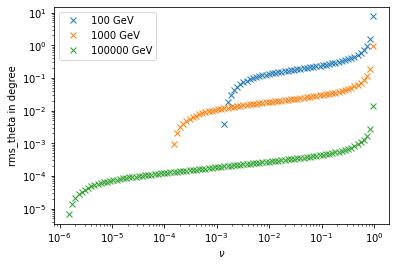

In [6]:
def get_new_psi_nuclint_ginneken_rms(E, nu, E_loss_min=0.136, m=0.1057, is_degree=True):
    # nu = (E - E_) / (E - m)
    print(len(nu))
    E_ = E - nu * (E - m)
    
    for e in E_:
        if E - e < E_loss_min:
            print(E - e)
    rms_theta = (0.39 / (E * (1 - nu))) * (np.sqrt(E) * nu * (1 - nu))**0.17 * (1 - 0.135/(E * nu))
    if is_degree:
        return np.rad2deg(rms_theta)
    else: return rms_theta

nu = np.logspace(-6, -0.01, 100)
E_loss_min = 0.136 # GeV
m = 0.1057


E = 100 # GeV
E_ = E - nu * (E - m)
plt.plot(nu[(E - E_) > E_loss_min], abs(get_new_psi_nuclint_ginneken_rms(E, nu[(E - E_) > E_loss_min], is_degree=True)), 'x', label='{} GeV'.format(E))

E = 1000 # GeV
E_ = E - nu * (E - m)
plt.plot(nu[(E - E_) > E_loss_min], abs(get_new_psi_nuclint_ginneken_rms(E, nu[(E - E_) > E_loss_min], is_degree=True)), 'x', label='{} GeV'.format(E))


E = 100000 # GeV
E_ = E - nu * (E - m)
plt.plot(nu[(E - E_) > E_loss_min], abs(get_new_psi_nuclint_ginneken_rms(E, nu[(E - E_) > E_loss_min], is_degree=True)), 'x', label='{} GeV'.format(E))



plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\nu$')
plt.ylabel('rms_theta in degree')
plt.legend()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.89it/s]


48
64
97


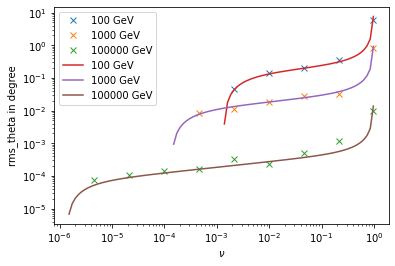

In [37]:
nu = np.logspace(-6, -0.01, 10)
n = 1000
E_loss_min = 0.136


E = 100 # GeV
E_ = E - nu * (E - m)
rms_values_l = []
for e_ in tqdm(E_):
    if E - e_ > E_loss_min:
        values = np.array([get_new_psi_nuclint(E, e_, rnd_state, nu_min=E_loss_min, is_degree=True) for i in range(n)])
        rms_value = np.sqrt(np.sum(values**2) / len(values)) 
        rms_values_l.append(rms_value)

plt.plot(nu[(E - E_)>E_loss_min], rms_values_l, 'x', label='{} GeV'.format(E))


E = 1000 # GeV
E_ = E - nu * (E - m)
rms_values_l = []
for e_ in tqdm(E_):
    if E - e_ > E_loss_min:
        values = np.array([get_new_psi_nuclint(E, e_, rnd_state, nu_min=E_loss_min, is_degree=True) for i in range(n)])
        rms_value = np.sqrt(np.sum(values**2) / len(values)) 
        rms_values_l.append(rms_value)

plt.plot(nu[(E - E_)>E_loss_min], rms_values_l, 'x', label='{} GeV'.format(E))

E = 100000 # GeV
E_ = E - nu * (E - m)
rms_values_l = []
for e_ in tqdm(E_):
    if E - e_ > E_loss_min:
        values = np.array([get_new_psi_nuclint(E, e_, rnd_state, nu_min=E_loss_min, is_degree=True) for i in range(n)])
        rms_value = np.sqrt(np.sum(values**2) / len(values)) 
        rms_values_l.append(rms_value)

plt.plot(nu[(E - E_)>E_loss_min], rms_values_l, 'x', label='{} GeV'.format(E))


########################### VAN GINNEKEN #################
nu = np.logspace(-6, -0.01, 100)
E = 100 # GeV
E_ = E - nu * (E - m)
plt.plot(nu[(E - E_) > E_loss_min], abs(get_new_psi_nuclint_ginneken_rms(E, nu[(E - E_) > E_loss_min], is_degree=True)), '-', label='{} GeV'.format(E))

E = 1000 # GeV
E_ = E - nu * (E - m)
plt.plot(nu[(E - E_) > E_loss_min], abs(get_new_psi_nuclint_ginneken_rms(E, nu[(E - E_) > E_loss_min], is_degree=True)), '-', label='{} GeV'.format(E))


E = 100000 # GeV
E_ = E - nu * (E - m)
plt.plot(nu[(E - E_) > E_loss_min], abs(get_new_psi_nuclint_ginneken_rms(E, nu[(E - E_) > E_loss_min], is_degree=True)), '-', label='{} GeV'.format(E))



plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\nu$')
plt.ylabel('rms_theta in degree')
plt.legend()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.25it/s]

48
64
97


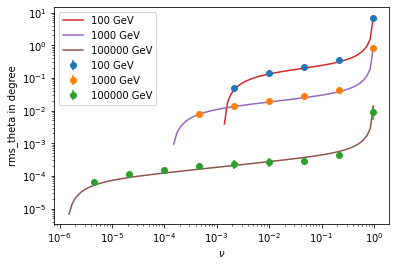

In [74]:
nu = np.logspace(-6, -0.01, 10)
n = 1000
N = 20
E_loss_min = 0.136


E = 100 # GeV
E_ = E - nu * (E - m)
rms_values_l_N = []
for l in tqdm(range(N)):
    rms_values_l = []
    for e_ in E_:      
        if E - e_ > E_loss_min:
            values = np.array([get_new_psi_nuclint(E, e_, rnd_state, nu_min=E_loss_min, is_degree=True) for i in range(n)])
            rms_value = np.sqrt(np.sum(values**2) / len(values)) 
            rms_values_l.append(rms_value)
    rms_values_l_N.append(rms_values_l)

plt.errorbar(nu[(E - E_)>E_loss_min], np.mean(rms_values_l_N, axis=0), yerr=np.std(rms_values_l_N, axis=0), fmt='o', label='{} GeV'.format(E))



E = 1000 # GeV
E_ = E - nu * (E - m)
rms_values_l_N = []
for l in tqdm(range(N)):
    rms_values_l = []
    for e_ in E_:      
        if E - e_ > E_loss_min:
            values = np.array([get_new_psi_nuclint(E, e_, rnd_state, nu_min=E_loss_min, is_degree=True) for i in range(n)])
            rms_value = np.sqrt(np.sum(values**2) / len(values)) 
            rms_values_l.append(rms_value)
    rms_values_l_N.append(rms_values_l)

plt.errorbar(nu[(E - E_)>E_loss_min], np.mean(rms_values_l_N, axis=0), yerr=np.std(rms_values_l_N, axis=0), fmt='o', label='{} GeV'.format(E))


E = 100000 # GeV
E_ = E - nu * (E - m)
rms_values_l_N = []
for l in tqdm(range(N)):
    rms_values_l = []
    for e_ in E_:      
        if E - e_ > E_loss_min:
            values = np.array([get_new_psi_nuclint(E, e_, rnd_state, nu_min=E_loss_min, is_degree=True) for i in range(n)])
            rms_value = np.sqrt(np.sum(values**2) / len(values)) 
            rms_values_l.append(rms_value)
    rms_values_l_N.append(rms_values_l)

plt.errorbar(nu[(E - E_)>E_loss_min], np.mean(rms_values_l_N, axis=0), yerr=np.std(rms_values_l_N, axis=0), fmt='o', label='{} GeV'.format(E))






########################### VAN GINNEKEN #################
nu = np.logspace(-6, -0.01, 100)
E = 100 # GeV
E_ = E - nu * (E - m)
plt.plot(nu[(E - E_) > E_loss_min], abs(get_new_psi_nuclint_ginneken_rms(E, nu[(E - E_) > E_loss_min], is_degree=True)), '-', label='{} GeV'.format(E))

E = 1000 # GeV
E_ = E - nu * (E - m)
plt.plot(nu[(E - E_) > E_loss_min], abs(get_new_psi_nuclint_ginneken_rms(E, nu[(E - E_) > E_loss_min], is_degree=True)), '-', label='{} GeV'.format(E))


E = 100000 # GeV
E_ = E - nu * (E - m)
plt.plot(nu[(E - E_) > E_loss_min], abs(get_new_psi_nuclint_ginneken_rms(E, nu[(E - E_) > E_loss_min], is_degree=True)), '-', label='{} GeV'.format(E))



plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\nu$')
plt.ylabel('rms_theta in degree')
plt.legend()

# Photnuclear interaction - check sampling theta

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:29<00:00, 33773.88it/s]


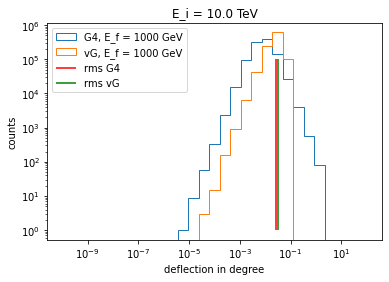

In [98]:
E = 10000 # GeV 
E_ = 1000 # GeV

N = 1000000
G4 = [] 
vG = []
for i in tqdm(range(N)):
    angle = get_new_psi_nuclint(E, E_, rnd_state, nu_min=E_loss_min, is_degree=True) 
    G4.append(angle)
    angle = get_new_psi_nuclint_ginneken(E, E_, rnd_state, is_degree=True)   
    vG.append(angle)

bins = np.logspace(-10, 2, 30)
plt.hist(G4, histtype='step', bins=bins, label='G4, E_f = {} GeV'.format(E_))
plt.hist(vG, histtype='step', bins=bins, label='vG, E_f = {} GeV'.format(E_))
plt.vlines(np.sqrt(np.sum(np.array(G4)**2) / len(np.array(G4))), 1, 1e6, color='red', label='rms G4')
plt.vlines(np.sqrt(np.sum(np.array(vG)**2) / len(np.array(vG))), 1, 1e6, color='green', label='rms vG')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in degree')
plt.ylabel('counts')
plt.title('E_i = {} TeV'.format(E/1e3))
plt.legend(loc='upper left')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:30<00:00, 32787.91it/s]


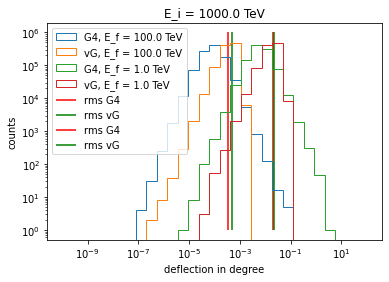

In [99]:
E = 1000000 # GeV 
bins = np.logspace(-10, 2, 30)
N = 1000000

E_ = 100000 # GeV
G4 = [] 
vG = []
for i in tqdm(range(N)):
    angle = get_new_psi_nuclint(E, E_, rnd_state, nu_min=E_loss_min, is_degree=True) 
    G4.append(angle)
    angle = get_new_psi_nuclint_ginneken(E, E_, rnd_state, is_degree=True)   
    vG.append(angle)

plt.hist(G4, histtype='step', bins=bins, label='G4, E_f = {} TeV'.format(E_/1e3))
plt.hist(vG, histtype='step', bins=bins, label='vG, E_f = {} TeV'.format(E_/1e3))
plt.vlines(np.sqrt(np.sum(np.array(G4)**2) / len(np.array(G4))), 1, 1e6, color='red', label='rms G4')
plt.vlines(np.sqrt(np.sum(np.array(vG)**2) / len(np.array(vG))), 1, 1e6, color='green', label='rms vG')


E_ = 1000 # GeV
G4 = [] 
vG = []
for i in tqdm(range(N)):
    angle = get_new_psi_nuclint(E, E_, rnd_state, nu_min=E_loss_min, is_degree=True) 
    G4.append(angle)
    angle = get_new_psi_nuclint_ginneken(E, E_, rnd_state, is_degree=True)   
    vG.append(angle)

plt.hist(G4, histtype='step', bins=bins, label='G4, E_f = {} TeV'.format(E_/1e3))
plt.hist(vG, histtype='step', bins=bins, label='vG, E_f = {} TeV'.format(E_/1e3))
plt.vlines(np.sqrt(np.sum(np.array(G4)**2) / len(np.array(G4))), 1, 1e6, color='red', label='rms G4')
plt.vlines(np.sqrt(np.sum(np.array(vG)**2) / len(np.array(vG))), 1, 1e6, color='green', label='rms vG')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in degree')
plt.ylabel('counts')
plt.title('E_i = {} TeV'.format(E/1e3))
plt.legend(loc='upper left')

# Check default tracks

In [ ]:
### run data
param_name = 'default'

deflection = ['BremsTsaiApproximation',
              'IonizNaiv',
              'PhotonuclearBorogPetrukhin',
              'EpairGinneken']

# deflection = ['tsaiapproximationbremsstrahlung', 
#               'naivionization',
#               'borogpetrukhinnuclearinteraction',
#              'kelnerpairproduction']

tracks_default = propagate_deflected_muons_custom(E_i_final, E_f_final, deflection=deflection, table_path=table_path)

deflection_default = [] 
for track in tqdm(tracks_default):
    d = get_angle_deviation(track.track_directions()[0].spherical_coordinates[1], 
                            track.track_directions()[0].spherical_coordinates[2], 
                            track.track_directions()[-1].spherical_coordinates[1], 
                            track.track_directions()[-1].spherical_coordinates[2])
    deflection_default.append(np.rad2deg(d))

In [ ]:
### check default tracks
stoch_loss = []
cont_loss = []
stoch_defl = []
cont_defl = []
brems_loss = []
brems_e = []
brems_defl = []
epair_loss = []
epair_e = []
epair_defl = []
nuclint_loss = []
nuclint_e = []
nuclint_defl = []
ioniz_loss = []
ioniz_e = []
ioniz_defl = []
for track in tqdm(tracks_default): # [:1]): ### choose only first track
    e_last = track.track_energies()[0]
    theta_last = track.track_directions()[0].spherical_coordinates[2]
    phi_last = track.track_directions()[0].spherical_coordinates[1]
    for typ, e, direction in zip(track.track_types()[1:], track.track_energies()[1:], track.track_directions()[1:]):
        e_lost = (e_last - e) / 1e3
        e_last /= 1e3
        defl_angle = get_angle_deviation(phi_last, theta_last, direction.spherical_coordinates[1], direction.spherical_coordinates[2])
        if str(typ) in ['Interaction_Type.epair',\
                            'Interaction_Type.brems',\
                            'Interaction_Type.photonuclear',\
                            'Interaction_Type.ioniz']:
            stoch_loss.append(e_lost)
            stoch_defl.append(defl_angle)
            if str(typ) == 'Interaction_Type.brems':
                brems_loss.append(e_lost)
                brems_e.append(e_last) #### MUST BE CHECKED FIRST!!
                brems_defl.append(defl_angle)
            if str(typ) == 'Interaction_Type.epair':
                epair_loss.append(e_lost)
                epair_e.append(e_last) #### MUST BE CHECKED FIRST!!
                epair_defl.append(defl_angle)
            if str(typ) == 'Interaction_Type.photonuclear':
                nuclint_loss.append(e_lost)
                nuclint_e.append(e_last) #### MUST BE CHECKED FIRST!!
                nuclint_defl.append(defl_angle)
            if str(typ) == 'Interaction_Type.ioniz':
                ioniz_loss.append(e_lost)
                ioniz_e.append(e_last) #### MUST BE CHECKED FIRST!!
                ioniz_defl.append(defl_angle)
        elif str(typ) == 'Interaction_Type.continuousenergyloss': 
            cont_loss.append(e_lost)
            cont_defl.append(defl_angle)
        e_last = e
        theta_last = direction.spherical_coordinates[2]
        phi_last = direction.spherical_coordinates[1]

# Check brems nuclint tracks

In [ ]:
### run data
param_name = 'brems_nuclint'
deflection = ['tsaiparametrizationbremsstrahlungginneken', 
              'naivionization',
              'bjorkennuclearinteraction',
              'kelnerpairproduction']

tracks_brems_nuclint = propagate_deflected_muons_custom(E_i_final, E_f_final, deflection=deflection, table_path=table_path)

deflection_brems_nuclint = [] 
for track in tqdm(tracks_brems_nuclint):
    d = get_angle_deviation(track.track_directions()[0].spherical_coordinates[1], track.track_directions()[0].spherical_coordinates[2], track.track_directions()[-1].spherical_coordinates[1], track.track_directions()[-1].spherical_coordinates[2])
    deflection_brems_nuclint.append(np.rad2deg(d))

In [ ]:
### check brems nuclint tracks
stoch_loss_vG = []
cont_loss_vG = []
stoch_defl_vG = []
cont_defl_vG = []
brems_loss_vG = []
brems_e_vG = []
brems_defl_vG = []
epair_loss_vG = []
epair_e_vG = []
epair_defl_vG = []
nuclint_loss_vG = []
nuclint_e_vG = []
nuclint_defl_vG = []
ioniz_loss_vG = [] 
ioniz_e_vG = [] 
ioniz_defl_vG = []
for track in tqdm(tracks_brems_nuclint): # [:1]): ### choose only first track
    e_last = track.track_energies()[0]
    theta_last = track.track_directions()[0].spherical_coordinates[2]
    phi_last = track.track_directions()[0].spherical_coordinates[1]
    for typ, e, direction in zip(track.track_types()[1:], track.track_energies()[1:], track.track_directions()[1:]):
        e_lost = (e_last - e) / 1e3
        e_last /= 1e3
        defl_angle = get_angle_deviation(phi_last, theta_last, direction.spherical_coordinates[1], direction.spherical_coordinates[2])
        if str(typ) in ['Interaction_Type.epair',\
                            'Interaction_Type.brems',\
                            'Interaction_Type.photonuclear',\
                            'Interaction_Type.ioniz']:
            stoch_loss_vG.append(e_lost)
            stoch_defl_vG.append(defl_angle)
            if str(typ) == 'Interaction_Type.brems':
                brems_loss_vG.append(e_lost)
                brems_e_vG.append(e_last) #### MUST BE CHECKED FIRST!!
                brems_defl_vG.append(defl_angle)
            if str(typ) == 'Interaction_Type.epair':
                epair_loss_vG.append(e_lost)
                epair_e_vG.append(e_last) #### MUST BE CHECKED FIRST!!
                epair_defl_vG.append(defl_angle)
            if str(typ) == 'Interaction_Type.photonuclear':
                nuclint_loss_vG.append(e_lost)
                nuclint_e_vG.append(e_last) #### MUST BE CHECKED FIRST!!
                nuclint_defl_vG.append(defl_angle)
            if str(typ) == 'Interaction_Type.ioniz':
                ioniz_loss_vG.append(e_lost)
                ioniz_e_vG.append(e_last) #### MUST BE CHECKED FIRST!!
                ioniz_defl_vG.append(defl_angle)
        elif str(typ) == 'Interaction_Type.continuousenergyloss': 
            cont_loss_vG.append(e_lost)
            cont_defl_vG.append(defl_angle)
        e_last = e
        theta_last = direction.spherical_coordinates[2]
        phi_last = direction.spherical_coordinates[1]

# Sample deflections

In [ ]:
### brems
brems_defl_default_ex = []
brems_defl_vG_ex = []
brems_defl_vG_ex_Z8 = []
brems_defl_vG_ex_Z82 = []
for e, e_loss in zip(brems_e, brems_loss):
    brems_defl_default_ex.append(get_new_psi_brems(e, e-e_loss, rnd_state, is_degree=False))
    brems_defl_vG_ex.append(get_brems_theta_vG(e, e-e_loss, rnd_state, is_degree=False))
    brems_defl_vG_ex_Z8.append(get_brems_theta_vG(e, e-e_loss, rnd_state, Z=8, is_degree=False))
    brems_defl_vG_ex_Z82.append(get_brems_theta_vG(e, e-e_loss, rnd_state, Z=82, is_degree=False))

### epair    
epair_defl_default_ex = []
for e, e_loss in zip(epair_e, epair_loss):
    epair_defl_default_ex.append(get_new_psi_pairprod_exp(e, e-e_loss, rnd_state, is_degree=False))

### nuclint    
nuclint_defl_default_ex = []
nuclint_defl_vG_ex = []
for e, e_loss in zip(nuclint_e, nuclint_loss):
    nuclint_defl_default_ex.append(get_new_psi_nuclint(e, e-e_loss, rnd_state, is_degree=False))
    nuclint_defl_vG_ex.append(get_new_psi_nuclint_ginneken(e, e-e_loss, rnd_state, is_degree=False))
    
### ioniz    
ioniz_defl_default_ex = []
for e, e_loss in zip(ioniz_e, ioniz_loss):
    ioniz_defl_default_ex.append(get_new_psi_deltaE_NEW(e, e-e_loss, is_degree=False))

## Plot default tracks

In [ ]:
bins = np.logspace(-15, 2, 100)

plt.hist(np.rad2deg(brems_defl_default_ex), bins=bins, histtype='step', color=colors['brems'], label='brems default')
plt.hist(np.rad2deg(nuclint_defl_default_ex), bins=bins, histtype='step', color=colors['nuclint'], label='nuclint default')
plt.hist(np.rad2deg(epair_defl_default_ex), bins=bins, histtype='step', color=colors['epair'], label='epair')
plt.hist(np.rad2deg(ioniz_defl_default_ex), bins=bins, histtype='step', color=colors['ioniz'], label='ioniz')

total_defl_default = list(flatten([brems_defl_default_ex, nuclint_defl_default_ex, epair_defl_default_ex, ioniz_defl_default_ex]))
plt.hist(np.rad2deg(total_defl_default), bins=bins, histtype='step', color='black', label='total')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in deg')
plt.ylabel('counts')
plt.legend(loc='upper left')
plt.tight_layout()
if save_plot:
    plt.savefig(plot_dir + '{}_{}_{}events_default.pdf'.format(energy_name(E_i), energy_name(E_f), n_events))

# ratio of zeros
print('ratio of zeros: ', np.sum(np.array(stoch_defl)==0)/len(stoch_defl)) # angle calculated in propagation
print('ratio of zeros (extern): ', np.sum(np.array(total_defl_default)==0)/len(total_defl_default))

## Plots brems nuclint tracks

In [ ]:
bins = np.logspace(-15, 2, 100)

plt.hist(np.rad2deg(brems_defl_vG_ex), bins=bins, histtype='step', color=colors['brems'], label='brems vG')
plt.hist(np.rad2deg(nuclint_defl_vG_ex), bins=bins, histtype='step', color=colors['nuclint'], label='nuclint vG')
plt.hist(np.rad2deg(epair_defl_default_ex), bins=bins, histtype='step', color=colors['epair'], label='epair')
plt.hist(np.rad2deg(ioniz_defl_default_ex), bins=bins, histtype='step', color=colors['ioniz'], label='ioniz')

total_defl_vG = list(flatten([brems_defl_vG_ex, nuclint_defl_vG_ex, epair_defl_default_ex, ioniz_defl_default_ex]))
plt.hist(np.rad2deg(total_defl_vG), bins=bins, histtype='step', color='black', label='total')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in deg')
plt.ylabel('counts')
plt.legend(loc='upper left')
plt.tight_layout()
if save_plot:
    plt.savefig(plot_dir + '{}_{}_{}events_vG.pdf'.format(energy_name(E_i), energy_name(E_f), n_events))

# ratio of zeros
print('ratio of zeros: ', np.sum(np.array(stoch_defl_vG)==0)/len(stoch_defl_vG)) # angle calculated in propagation
print('ratio of zeros (extern): ', np.sum(np.array(total_defl_vG)==0)/len(total_defl_vG))

# Comparison

## brems

In [ ]:
bins = np.logspace(-15, 2, 100)

n_0 = plt.hist(brems_defl, bins=bins, histtype='step', label='brems default proposal')
n_00 = plt.hist(brems_defl_vG, bins=bins, histtype='step', label='brems vG proposal')

n_1 = plt.hist(brems_defl_default_ex, bins=bins, histtype='step', label='brems default python')
n_2 = plt.hist(brems_defl_vG_ex, bins=bins, histtype='step', label='brems vG python')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in rad')
plt.legend(loc='best')
plt.tight_layout()
if save_plot:
    plt.savefig(plot_dir + '{}_{}_{}events_compare_brems.pdf'.format(energy_name(E_i), energy_name(E_f), n_events))
print(np.sum(n_0[0]))
print(np.sum(n_00[0]))
print(np.sum(n_1[0]))
print(np.sum(n_2[0]))

## epair 

In [ ]:
bins = np.logspace(-15, 2, 100)

n_0 = plt.hist(epair_defl, bins=bins, histtype='step', label='epair default proposal')
# n_00 = plt.hist(epair_defl_vG, bins=bins, histtype='step', label='epair vG proposal')

n_1 = plt.hist(epair_defl_default_ex, bins=bins, histtype='step', label='epair default python')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in rad')
plt.legend(loc='best')
plt.tight_layout
if save_plot:
    plt.savefig(plot_dir + '{}_{}_{}events_compare_epair.pdf'.format(energy_name(E_i), energy_name(E_f), n_events))
print(np.sum(n_0[0]))
# print(np.sum(n_00[0]))
print(np.sum(n_1[0]))

## nuclint

In [ ]:
bins = np.logspace(-15, 2, 100)

n_0 = plt.hist(nuclint_defl, bins=bins, histtype='step', label='nuclint default proposal')
n_00 = plt.hist(nuclint_defl_vG, bins=bins, histtype='step', label='nuclint vG proposal')


n_1 = plt.hist(nuclint_defl_default_ex, bins=bins, histtype='step', label='nuclint default python')
n_2 = plt.hist(nuclint_defl_vG_ex, bins=bins, histtype='step', label='nuclint vG python')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in rad')
plt.legend(loc='upper left')
plt.tight_layout()
if save_plot:
    plt.savefig(plot_dir + '{}_{}_{}events_compare_nuclint.pdf'.format(energy_name(E_i), energy_name(E_f), n_events))
print(np.sum(n_0[0]))
print(np.sum(n_00[0]))
print(np.sum(n_1[0]))
print(np.sum(n_2[0]))

## ioniz

In [ ]:
bins = np.logspace(-15, 2, 100)

n_0 = plt.hist(ioniz_defl, bins=bins, histtype='step', label='ioniz default proposal')
# n_00 = plt.hist(ioniz_defl_vG, bins=bins, histtype='step', label='ioniz vG proposal')

n_1 = plt.hist(ioniz_defl_default_ex, bins=bins, histtype='step', label='ioniz default python')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in rad')
plt.legend(loc='upper left')
plt.tight_layout()
if save_plot:
    plt.savefig(plot_dir + '{}_{}_{}events_compare_ioniz.pdf'.format(energy_name(E_i), energy_name(E_f), n_events))
print(np.sum(n_0[0]))
# print(np.sum(n_00[0]))
print(np.sum(n_1[0]))

# Check brems vG different Z

In [ ]:
bins = np.logspace(-15, 2, 100)

plt.hist(brems_defl_vG, bins=bins, histtype='step', label='brems vG Ice proposal')
plt.hist(brems_defl_vG_ex, bins=bins, histtype='step', label='brems vG Z=1 python')
plt.hist(brems_defl_vG_ex_Z8, bins=bins, histtype='step', label='brems vG Z=8 python')
plt.hist(brems_defl_vG_ex_Z82, bins=bins, histtype='step', label='brems vG Z=82 python')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('deflection in rad')
plt.legend(loc='lower left')
plt.tight_layout()
if save_plot:
    plt.savefig(plot_dir + '{}_{}_{}events_compare_brems_differentZ.pdf'.format(energy_name(E_i), energy_name(E_f), n_events))